In [1]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

save_initial = True

In [51]:
# Aggregate all seasons into one directory
if save_initial:
    input_paths    = [f"./data/20{i}-{i+1}/players/" for i in range(18, 24)]
    init_path      = "./data/2023-24/players/"
    save_path      = "./data/2018-24/"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    for i in os.listdir(init_path):
        if i[0] == '.':
            continue
        df         = []
        for j in input_paths:
            for k in os.listdir(j):
                if k.split("_")[:-1] != i.split("_")[:-1]:
                    continue
                t  = pd.read_csv(os.path.join(j, k, "gw.csv"))
                t['season'] = j.split('/')[2]
                df+= [t]
        df         = pd.concat(df, ignore_index=True).sort_values(by='kickoff_time')
        df['player']= "_".join(i.split("_")[:-1])
        df.to_csv(os.path.join(save_path, f'{"_".join(i.split("_")[:-1])}.csv'), index=False)

{'winning_goals', 'loaned_out', 'penalties_conceded', 'big_chances_missed', 'errors_leading_to_goal', 'tackled', 'kickoff_time_formatted', 'completed_passes', 'clearances_blocks_interceptions', 'fouls', 'target_missed', 'ea_index', 'Unnamed: 0.1.1.1', 'id', 'tackles', 'loaned_in', 'attempted_passes', 'open_play_crosses', 'errors_leading_to_goal_attempt', 'recoveries', 'key_passes', 'dribbles', 'offside', 'big_chances_created'}


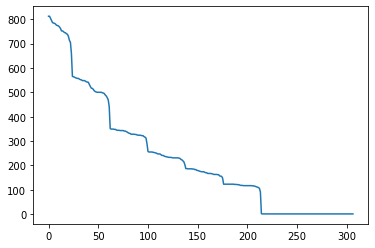

In [52]:
# Make cummulative frequency curve of games listed per player
# Figure out what columns are not present in all dfs

if save_initial:
    dfs            = []
    cols           = set()
    not_all        = set()
    for i in os.listdir(save_path):
        dfs       += [pd.read_csv(os.path.join(save_path, i))]
        cols       = cols.union(set(dfs[-1].columns))
        not_all    = not_all.union(set(cols).difference(set(dfs[-1].columns)))

    numGames       = [len(i) for i in dfs]
    total          = max(numGames)
    freq           = [0] * (total + 1)
    for i in numGames:
        freq[i]   += 1
    temp           = 0
    for i in range(len(freq) - 1, -1, -1):
        freq[i]   += temp
        temp       = freq[i]
    plt.plot(range(len(freq)), freq)

    print(not_all)
    

In [2]:
# Create training dataset: 
    #    train.csv containing (nx5m values), where each row is a flattened stat summary from past 5 games for one player
    #    labels.csv containing (nx1) values, total points in next game for each player
    
not_all      = {'target_missed', 'fouls', 'recoveries', 'key_passes', 
                'clearances_blocks_interceptions', 'big_chances_created', 
                'errors_leading_to_goal_attempt', 'completed_passes', 'tackled', 
                'kickoff_time_formatted', 'attempted_passes', 'tackles', 'offside', 
                'big_chances_missed', 'loaned_in', 'errors_leading_to_goal', 'penalties_conceded', 
                'loaned_out', 'winning_goals', 'open_play_crosses', 'dribbles', 'id', 'ea_index'}
columnNames  = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
                'expected_assists', 'expected_goal_involvements', 'expected_goals',
                'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
                'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
                'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
                'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
                'threat', 'total_points', 'transfers_balance', 'transfers_in',
                'transfers_out', 'value', 'was_home', 'yellow_cards',
                'attempted_passes', 'big_chances_created', 'big_chances_missed',
                'clearances_blocks_interceptions', 'completed_passes', 'dribbles',
                'ea_index', 'errors_leading_to_goal', 'errors_leading_to_goal_attempt',
                'fouls', 'id', 'key_passes', 'kickoff_time_formatted', 'loaned_in',
                'loaned_out', 'offside', 'open_play_crosses', 'penalties_conceded',
                'recoveries', 'tackled', 'tackles', 'target_missed', 'winning_goals',
                'own_FDR', 'opp_FDR', 'season', 'gw', 'player']
drop_columns = {'transfers_balance', 'fixture', 'expected_goals_conceded', 'element',
                'expected_assists', 'expected_goal_involvements', 'expected_goals',
                'ict_index', 'starts', 'team_a_score', 'team_h_score',
                }.union(not_all)
categorical  = ['opponent_team', 'was_home', 'season', 'player']
normalize    = ['transfers_in', 'transfers_out', 'value', 'selected']

columnNames  = [i for i in columnNames if i not in drop_columns]
print(columnNames)

['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'threat', 'total_points', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'own_FDR', 'opp_FDR', 'season', 'gw', 'player']


In [3]:
input_path       = "./data/2023-24/players"
players          = set(["_".join(i.split("_")[:-1]) for i in os.listdir(input_path) if i[0] != '.'])
cleaner_map      = {" ".join(i.split("_")) : i for i in players}

position_map     = {i : set() for i in ["FWD", "MID", "DEF", "GK"]}
input_path       = "./data/2023-24/gws/"
for game in os.listdir(input_path):
    if game[:2] != "gw":
        continue
    df           = pd.read_csv(os.path.join(input_path, game))
    for row in range(len(df)):
        row = df.iloc[row]
        position_map[row["position"]].add(cleaner_map[row["name"]])
        players  = players.difference({cleaner_map[row["name"]]})
    if not players:
        break
print([(i, len(position_map[i])) for i in position_map])
print(players)
df

[('FWD', 104), ('MID', 354), ('DEF', 261), ('GK', 93)]
set()


,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Femi Seriki,DEF,Sheffield Utd,-0.5,0,0,0,0,0.0,653,...,5,0,0.0,0,413,601,188,39,True,0
1,Josh Brooking,DEF,Chelsea,0.0,0,0,0,0,0.0,723,...,4,2,0.0,0,-14,18,32,40,True,0
2,Radek Vítek,GK,Man Utd,0.0,0,0,0,0,0.0,669,...,0,3,0.0,0,-96,0,96,40,True,0
3,Jack Hinshelwood,MID,Brighton,4.0,0,0,29,0,6.9,621,...,1,4,21.0,7,-593,1041,1634,45,True,0
4,Jadon Sancho,MID,Man Utd,0.0,0,0,0,0,0.0,397,...,0,3,0.0,0,-72,0,72,67,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,Kyle Walker,DEF,Man City,3.7,0,0,16,0,36.5,369,...,3,1,9.0,2,-86560,26799,113359,55,False,0
805,Jacob Brown,FWD,Luton,-0.7,0,0,1,0,0.5,631,...,4,4,7.0,1,-541,144,685,49,False,0
806,Vicente Guaita,GK,Crystal Palace,0.0,0,0,0,0,0.0,227,...,1,4,0.0,0,-108,0,108,44,False,0
807,Braian Ojeda Rodríguez,MID,Nott'm Forest,0.0,0,0,0,0,0.0,459,...,1,1,0.0,0,0,0,0,45,False,0


In [6]:
master_dir           = "./data/2018-24_processed/"
if not os.path.exists(master_dir):
        os.mkdir(master_dir)
for position, players in position_map.items():
    # NaN analysis
    input_path       = "./data/2018-24/"
    dfs              = [pd.read_csv(os.path.join(input_path, i + ".csv")).loc[:, columnNames] 
                        for i in players]
    megaDf           = pd.concat(dfs, axis=0, ignore_index=True)
    counts           = megaDf.isna().sum()
    assert counts.sum() == 0 # Insert NaN handling if NaNs
        
    # Normalization
    save_path        = master_dir + f"{position}/"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    means            = {col:count for col, count in megaDf.mean().items()}
    sds              = {col:count for col, count in megaDf.std().items()}
    print(position)
    print(pd.concat([megaDf.mean(), megaDf.std()], axis = 1), "\n")    

    for name, df in zip(players, dfs):
        for col in categorical:
            df[col] = df[col].map(str)
        for col in normalize:
            df[col] -= means[col]
            df[col] /= sds[col]
        df.to_csv(os.path.join(save_path, name), index = False)

FWD
                              0             1
assists                0.066149  2.828338e-01
bonus                  0.207820  6.888757e-01
bps                    5.687199  1.207310e+01
clean_sheets           0.103374  3.044676e-01
creativity             4.912533  9.224372e+00
goals_conceded         0.500268  9.303449e-01
goals_scored           0.144081  4.145099e-01
influence              7.684092  1.638360e+01
minutes               31.859802  3.831453e+01
opponent_team         10.518077  5.743508e+00
own_goals              0.000536  2.313879e-02
penalties_missed       0.003080  5.541420e-02
penalties_saved        0.000000  0.000000e+00
red_cards              0.001875  4.325970e-02
round                 18.657338  1.102580e+01
saves                  0.000000  0.000000e+00
selected          457434.295795  1.078711e+06
threat                13.149839  2.248034e+01
total_points           1.793117  3.055606e+00
transfers_in       36256.564676  1.022056e+05
transfers_out      32662.34159

In [5]:
trainColumns       = ["own_FDR_6", "opp_FDR_6"]
for j in ["_1", "_2", "_3", "_4", "_5"]: # 5 games
    trainColumns  += [i+j for i in columnNames]

for position, players in position_map.items():
    train          = []
    labels         = []

    input_path     = f"./data/2018-24_processed/{position}/"
    for i in tqdm(os.listdir(input_path)):
        if i[0] == '.':
            continue
        curr_path  = os.path.join(input_path, i)
        df         = pd.read_csv(curr_path)
        for label_row in range(5, len(df)):
            vector = np.array([df[i].iloc[label_row] for i in ["own_FDR", "opp_FDR"]])
            vector = np.concatenate([vector, df.iloc[label_row - 5:label_row].values.flatten()])
            label  = df['total_points'].iloc[label_row]
            train += [vector]
            labels+= [[label]]

    train          = pd.DataFrame(train, columns = trainColumns)
    labels         = pd.DataFrame(labels, columns = ["Points"])
    save_path      = f"./train_2018-24/{position}/"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    train.to_csv(os.path.join(save_path, 'inputs.csv'), index=False)
    labels.to_csv(os.path.join(save_path, 'labels.csv'), index=False)

 23%|██▎       | 166/708 [00:02<00:07, 70.83it/s]


FileNotFoundError: [Errno 2] No such file or directory: './data/2018-24_processed/MID/Owen_Dodgson.csv'

In [ ]:
train.head